# Transcriptional Unit Survey
Goal: Determine contribution of each TU to expression when there are overlapping TUs

In [1]:
# Promoter_Solving Modules
import numpy as np
from numpy import nan
import pandas as pd
import re

from itertools import product

from sklearn.model_selection import ParameterGrid

from sympy import *

import xgboost as xgb

from deap import algorithms, base, creator, tools

from pathlib import Path
import sys

sys.path.append('../../bitome2_workflows')
sys.path.append('../')

from promoter_solving_core import *

# Bitome Modules
%matplotlib inline
import matplotlib.pyplot as plt

from pymodulon.io import load_json_model
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
import shap
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from bitome.ml import *

sns.set_style('whitegrid')

shap.initjs()

/opt/miniconda3/envs/sym-seq-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

precise2 = load_json_model('../data/precise2.json.gz')

In [263]:
mg1655.tu_table

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,
ECK120008913,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0
ECK120008914,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0
ECK120008915,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0
ECK120008916,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0
ECK120008917,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0,4105785.0,4106379.0
...,...,...,...,...,...,...,...,...,...,...
ECK125302596,hemF,1.0,2552982.0,NaN,NaN,NaN,NaN,NaN,2552982.0,2554124.0
ECK125302597,tnaAB,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3888730.0,3891483.0
ECK125328143,aspXS,-1.0,4366951.0,NaN,NaN,NaN,NaN,NaN,4366839.0,4366951.0


In [268]:
# Cases where RegulonDB does not have tss information - a large number!
mg1655.tu_table.loc[mg1655.tu_table.loc[:,'tss'].isnull()]

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,
ECK120008920,aqpZ,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,915352.0,916047.0
ECK120008926,ldcC,1.0,NaN,Sigma38,NaN,NaN,NaN,NaN,209679.0,211820.0
ECK120008995,asnW,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,2057926.0,2058102.0
ECK120009022,secMA-mutT,1.0,NaN,NaN,NaN,NaN,NaN,NaN,107705.0,111433.0
ECK120009025,garD,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3275282.0,3276853.0
...,...,...,...,...,...,...,...,...,...,...
ECK125285343,argH,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4156850.0,4158223.0
ECK125286548,sokX,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2887353.0,2887411.0
ECK125286565,yabR,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,85467.0,85511.0


Can I make the assumption that the tss is either the location listed as left or right depending on whether the TU is on the forward or the reverse strand?

In [4]:
mg1655.gene_table

,left,right,strand,pseudo,name,cog,essential,y-ome,p1k_ctrl_log_tpm,p1k_median_log_tpm,...,pct25_log_tpm,max_log_tpm,min_log_tpm,mean_log_tpm,skew,range_log_tpm,max_to_median,min_to_median,low,in_complex
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0001,190,255,1,False,thrL,NaN,NaN,well-annotated,10.372833,8.862343,...,7.633022,14.327388,0.000000,9.079599,0.248526,14.327388,5.465045,-8.862343,False,True
b0002,337,2799,1,False,thrA,E,NaN,well-annotated,10.314562,9.605329,...,8.701393,11.771901,0.000000,9.268791,-1.946621,11.771901,2.166572,-9.605329,False,True
b0003,2801,3733,1,False,thrB,E,NaN,well-annotated,9.982251,9.232803,...,8.390286,11.460140,4.491162,8.992904,-0.955742,6.968977,2.227337,-4.741641,False,True
b0004,3734,5020,1,False,thrC,E,NaN,well-annotated,9.973666,9.274271,...,8.477273,11.319964,4.332273,8.973294,-1.313123,6.987691,2.045694,-4.941998,False,True
b0005,5234,5530,1,False,yaaX,NaN,NaN,y-ome,7.132482,6.283661,...,5.303001,11.817918,0.000000,6.008284,-0.431863,11.817918,5.534257,-6.283661,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4399,4636696,4638120,1,False,creC,T,NaN,well-annotated,4.093839,3.907608,...,3.608543,5.238244,1.617498,3.855763,-0.766133,3.620746,1.330636,-2.290110,False,True
b4400,4638178,4639530,1,False,creD,V,NaN,y-ome,2.350495,2.816195,...,2.468279,5.802777,1.187745,2.826627,0.689277,4.615032,2.986581,-1.628450,False,True
b4401,4639590,4640306,-1,False,arcA,T,NaN,well-annotated,9.267008,9.667090,...,NaN,12.783370,5.146081,9.631514,-1.812469,7.637289,3.112624,-4.524665,False,True


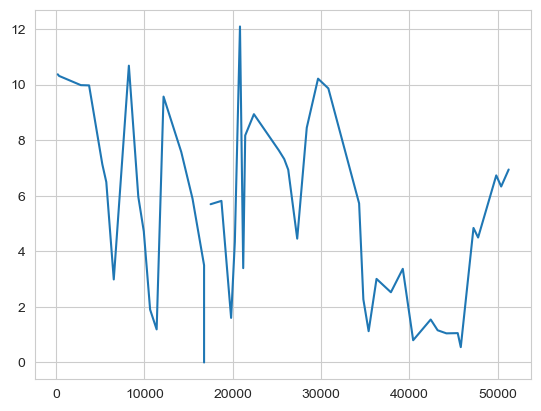

In [6]:
# Want to see how expression falls off with distance from TU
fig, ax = plt.subplots()
ax.plot(mg1655.gene_table.iloc[0:50,:].left, mg1655.gene_table.iloc[0:50,:].p1k_ctrl_log_tpm)

# Gene-TU DataFrame
We seem to be missing some TUs

In [545]:
mg1655.tu_table.loc[mg1655.tu_table.name == 'fimA']

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,


In [415]:
gene_tu = pd.DataFrame(0, index=mg1655.gene_table.index, columns=mg1655.tu_table.index)

for gene in gene_tu.index:
    tu_list = mg1655._gene_to_tus[gene]
    
    for tu in tu_list:
        gene_tu.loc[gene, tu] = 1

In [548]:
gene_tu.loc[gene_tu.loc[:,'ECK120008913'] == 1]

locus_tag,ECK120008913,ECK120008914,ECK120008915,ECK120008916,ECK120008917,ECK120008918,ECK120008919,ECK120008920,ECK120008921,ECK120008922,...,ECK125300411,ECK125300412,ECK125300413,ECK125302594,ECK125302595,ECK125302596,ECK125302597,ECK125328143,ECK125336160,ECK125336161
locus_tag,,,,,,,,,,,,,,,,,,,,,
b1744,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b1745,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b1746,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b1747,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b1748,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Attempt to solve as Ax=B

In [742]:
a = gene_tu.to_numpy(dtype=int)
b = 2**mg1655.gene_table.loc[:,'p1k_ctrl_log_tpm'].to_numpy() # Convert from log2(TPM) to TPM

In [743]:
i_to_drop = []
for i, tpm in enumerate(b):
    if not np.isfinite(tpm):
        i_to_drop.append(i)

In [744]:
# Remove nan results
a = np.delete(a, i_to_drop, axis=0)
b = np.delete(b, i_to_drop, axis=0)

In [745]:
# Correct gene index
gene_index = mg1655.gene_table.index.to_list()
gene_index = np.delete(gene_index, i_to_drop)

In [746]:
rank = np.linalg.matrix_rank(a)

In [747]:
print(rank)
print(shape(a))

2797
(4284, 3685)


In [748]:
# We do not have full row or full column rank...
import scipy
x, residuals, _, s = np.linalg.lstsq(a, b, rcond=None)

In [749]:
x

array([  3.79320123,   3.79320123,   3.79320123, ...,   0.        ,
        59.69662568, 167.43076215])

In [750]:
x = pd.Series(data=x, index=gene_tu.columns)
x

locus_tag
ECK120008913      3.793201
ECK120008914      3.793201
ECK120008915      3.793201
ECK120008916     60.554920
ECK120008917    115.045347
                   ...    
ECK125302596    -17.408248
ECK125302597      4.670934
ECK125328143      0.000000
ECK125336160     59.696626
ECK125336161    167.430762
Length: 3685, dtype: float64

### Checking the minimum value in the series

In [757]:
print(x.idxmin())
print(x.min())

ECK120009179
-8358.97994470108


In [759]:
gene_list = mg1655.gene_table.loc['b3983':'b3988'].index
TU_list = [TU for gene in mg1655.gene_table.loc[gene_list].index for TU in mg1655._gene_to_tus[gene]]
TU_list = list(set(TU_list))
mg1655.tu_table.loc[TU_list,:]

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,
ECK120009523,rplJL-rpoBC,1.0,4179623.0,NaN,NaN,NaN,NaN,NaN,4179623.0,4189613.0
ECK120009179,rpoBC,1.0,4181063.0,NaN,NaN,NaN,NaN,NaN,4181063.0,4189613.0
ECK120016932,rplL,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4180560.0,4180925.0
ECK120011093,rplKAJL-rpoBC,1.0,4178354.0,NaN,NaN,NaN,NaN,NaN,4178354.0,4189613.0


In [760]:
x.loc[TU_list]

locus_tag
ECK120009523    5285.411164
ECK120009179   -8358.979945
ECK120016932   -1607.317097
ECK120011093    4084.775839
dtype: float64

In [766]:
predicted_expression = a @ x
predicted_expression = pd.Series(data=predicted_expression, index=gene_index)
predicted_expression.loc[gene_list]

locus_tag
b3983    4084.775839
b3984    4084.775839
b3985    9370.187003
b3986    7762.869906
b3987    1011.207058
b3988    1011.207058
dtype: float64

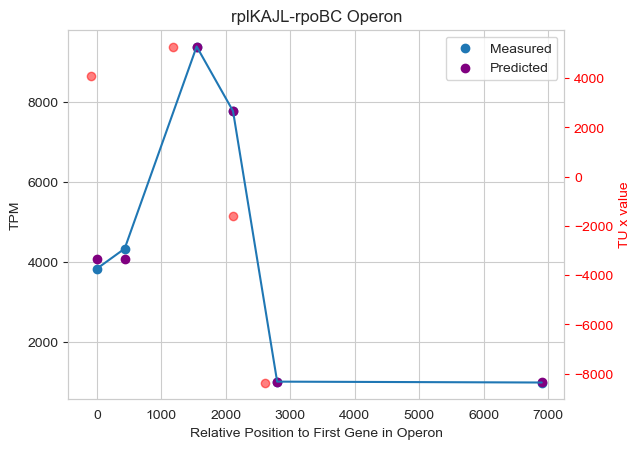

In [767]:
# Plot the x values
fig, ax = plt.subplots()
ax.plot(mg1655.gene_table.loc[gene_list,:].strand*(mg1655.gene_table.loc[gene_list,'left']-mg1655.gene_table.loc[gene_list[0],'left']), 2**mg1655.gene_table.loc[gene_list,'p1k_ctrl_log_tpm'])
ax.scatter(mg1655.gene_table.loc[gene_list,:].strand*(mg1655.gene_table.loc[gene_list,'left']-mg1655.gene_table.loc[gene_list[0],'left']), 2**mg1655.gene_table.loc[gene_list,'p1k_ctrl_log_tpm'], label='Measured')
ax.set_ylabel('TPM')

ax2 = ax.twinx()
ax2.scatter(mg1655.tu_table.loc[TU_list,:].strand*(mg1655.tu_table.loc[TU_list,:].left-mg1655.gene_table.loc[gene_list[0],'left']), x.loc[TU_list], c='r', alpha=0.5)
ax2.set_ylabel('TU x value', c='r')
ax2.grid(False)
ax2.tick_params(axis='y', colors='red')

ax.scatter(mg1655.gene_table.loc[gene_list,:].strand*(mg1655.gene_table.loc[gene_list,:].left-mg1655.gene_table.loc[gene_list[0],'left']), predicted_expression.loc[gene_list], c='purple', label='Predicted')

ax.set_xlabel('Relative Position to First Gene in Operon')
ax.set_title('rplKAJL-rpoBC Operon')
ax.legend()

### Identify all negative entries

### Converting back to log2(TPM)

In [751]:
new_x = np.log2(x)

divide by zero encountered in log2
invalid value encountered in log2


In [741]:
# Correct the nan values
for tpm in x:
    print(x)

locus_tag
ECK120008913    1.923416
ECK120008914    1.923416
ECK120008915    1.923416
ECK120008916    5.920172
ECK120008917    6.846059
                  ...   
ECK125302596         NaN
ECK125302597    2.223711
ECK125328143        -inf
ECK125336160    5.899577
ECK125336161    7.387421
Length: 3685, dtype: float64
locus_tag
ECK120008913    1.923416
ECK120008914    1.923416
ECK120008915    1.923416
ECK120008916    5.920172
ECK120008917    6.846059
                  ...   
ECK125302596         NaN
ECK125302597    2.223711
ECK125328143        -inf
ECK125336160    5.899577
ECK125336161    7.387421
Length: 3685, dtype: float64
locus_tag
ECK120008913    1.923416
ECK120008914    1.923416
ECK120008915    1.923416
ECK120008916    5.920172
ECK120008917    6.846059
                  ...   
ECK125302596         NaN
ECK125302597    2.223711
ECK125328143        -inf
ECK125336160    5.899577
ECK125336161    7.387421
Length: 3685, dtype: float64
locus_tag
ECK120008913    1.923416
ECK120008914    1.92341

In [736]:
x

locus_tag
ECK120008913    1.923416
ECK120008914    1.923416
ECK120008915    1.923416
ECK120008916    5.920172
ECK120008917    6.846059
                  ...   
ECK125302596         NaN
ECK125302597    2.223711
ECK125328143        -inf
ECK125336160    5.899577
ECK125336161    7.387421
Length: 3685, dtype: float64

### Check performance on the tsa TU cluster

In [732]:
gene_list = mg1655.gene_table.loc['b4167':'b4175'].index
TU_list = [TU for gene in mg1655.gene_table.loc[gene_list].index for TU in mg1655._gene_to_tus[gene]]
TU_list = list(set(TU_list))
mg1655.tu_table.loc[TU_list,:]

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,
ECK120033765,mutL-miaA-hfq-hflXKC,1.0,4397046.0,Sigma32,4397031.0,4397036.0,4397011.0,4397016.0,4397046.0,4404304.0
ECK120009426,yjeFE-amiB-mutL-miaA-hfq-hflXKC,1.0,4393677.0,Sigma70,4393665.0,4393670.0,4393640.0,4393645.0,4393677.0,4404304.0
ECK120009829,yjeFE-amiB-mutL-miaA-hfq-hflXKC,1.0,4393937.0,Sigma70,4393925.0,4393930.0,4393899.0,4393904.0,4393937.0,4404304.0
ECK120009830,yjeFE-amiB-mutL-miaA-hfq-hflXKC,1.0,4394035.0,Sigma70,4394025.0,4394030.0,4394001.0,4394006.0,4394035.0,4404304.0
ECK120033605,hfq-hflXKC,1.0,4400220.0,Sigma70,4400208.0,4400213.0,4400183.0,4400188.0,4400220.0,4404304.0
ECK120033597,hfq-hflXKC,1.0,4399801.0,Sigma70,4399788.0,4399793.0,4399765.0,4399770.0,4399801.0,4404304.0
ECK120033766,mutL-miaA-hfq-hflXKC,1.0,4397100.0,Sigma70,4397088.0,4397093.0,4397064.0,4397069.0,4397100.0,4404304.0
ECK120051393,tsaE-amiB-mutL-miaA-hfq-hflXKC,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4395585.0,4404304.0
ECK120033603,miaA-hfq-hflXKC,1.0,4399052.0,Sigma70,4399039.0,4399044.0,4399013.0,4399018.0,4399052.0,4404304.0


In [737]:
x.loc[TU_list]

locus_tag
ECK120033765   -2.415764
ECK120009426    4.620856
ECK120009829    4.620856
ECK120009830    4.620856
ECK120033605    6.067396
ECK120033597    6.067396
ECK120033766   -2.415764
ECK120051393         NaN
ECK120033603    7.604423
ECK120033604    6.067396
ECK120033602    7.604423
dtype: float64

In [739]:
predicted_expression = a @ 2**x
predicted_expression = pd.Series(data=predicted_expression, index=gene_index)
predicted_expression

b0001   NaN
b0002   NaN
b0003   NaN
b0004   NaN
b0005   NaN
         ..
b4399   NaN
b4400   NaN
b4401   NaN
b4402   NaN
b4403   NaN
Length: 4284, dtype: float64

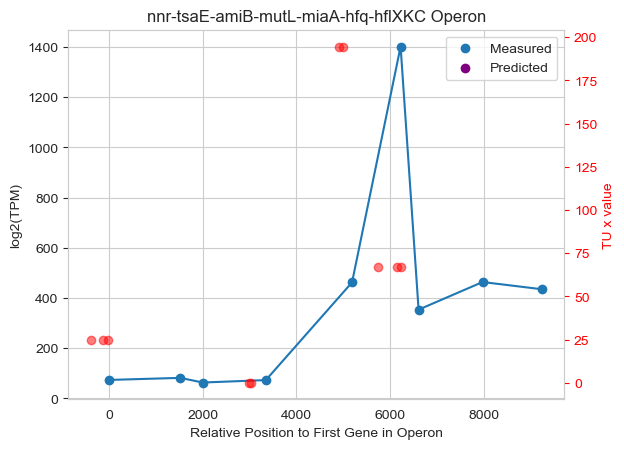

In [740]:
# Plot the x values
fig, ax = plt.subplots()
ax.plot(mg1655.gene_table.loc[gene_list,:].strand*(mg1655.gene_table.loc[gene_list,'left']-mg1655.gene_table.loc[gene_list[0],'left']), 2**mg1655.gene_table.loc[gene_list,'p1k_ctrl_log_tpm'])
ax.scatter(mg1655.gene_table.loc[gene_list,:].strand*(mg1655.gene_table.loc[gene_list,'left']-mg1655.gene_table.loc[gene_list[0],'left']), 2**mg1655.gene_table.loc[gene_list,'p1k_ctrl_log_tpm'], label='Measured')
ax.set_ylabel('log2(TPM)')

ax2 = ax.twinx()
ax2.scatter(mg1655.tu_table.loc[TU_list,:].strand*(mg1655.tu_table.loc[TU_list,:].left-mg1655.gene_table.loc[gene_list[0],'left']), 2**x.loc[TU_list], c='r', alpha=0.5)
ax2.set_ylabel('TU x value', c='r')
ax2.grid(False)
ax2.tick_params(axis='y', colors='red')

ax.scatter(mg1655.gene_table.loc[gene_list,:].strand*(mg1655.gene_table.loc[gene_list,:].left-mg1655.gene_table.loc[gene_list[0],'left']), predicted_expression.loc[gene_list], c='purple', label='Predicted')

ax.set_xlabel('Relative Position to First Gene in Operon')
ax.set_title('nnr-tsaE-amiB-mutL-miaA-hfq-hflXKC Operon')
ax.legend()

In [ ]:
# Plot the x values
fig, ax = plt.subplots()
ax.plot(mg1655.gene_table.loc[gene_list,:].strand*(mg1655.gene_table.loc[gene_list,'left']-mg1655.gene_table.loc[gene_list[0],'left']), mg1655.gene_table.loc[gene_list,'p1k_ctrl_log_tpm'])
ax.scatter(mg1655.gene_table.loc[gene_list,:].strand*(mg1655.gene_table.loc[gene_list,'left']-mg1655.gene_table.loc[gene_list[0],'left']), mg1655.gene_table.loc[gene_list,'p1k_ctrl_log_tpm'], label='Measured')
ax.set_ylabel('log2(TPM)')

ax2 = ax.twinx()
ax2.scatter(mg1655.tu_table.loc[TU_list,:].strand*(mg1655.tu_table.loc[TU_list,:].left-mg1655.gene_table.loc[gene_list[0],'left']), x.loc[TU_list], c='r', alpha=0.5)
ax2.set_ylabel('TU x value', c='r')
ax2.grid(False)
ax2.tick_params(axis='y', colors='red')

ax.scatter(mg1655.gene_table.loc[gene_list,:].strand*(mg1655.gene_table.loc[gene_list,:].left-mg1655.gene_table.loc[gene_list[0],'left']), predicted_expression.loc[gene_list], c='purple', label='Predicted')

ax.set_xlabel('Relative Position to First Gene in Operon')
ax.set_title('nnr-tsaE-amiB-mutL-miaA-hfq-hflXKC Operon')
ax.legend()

In [690]:
gene_tu.loc[gene_list,TU_list]

locus_tag,ECK120033765,ECK120009426,ECK120009829,ECK120009830,ECK120033605,ECK120033597,ECK120033766,ECK120051393,ECK120033603,ECK120033604,ECK120033602
locus_tag,,,,,,,,,,,
b4167,0,1,1,1,0,0,0,0,0,0,0
b4168,0,1,1,1,0,0,0,1,0,0,0
b4169,0,1,1,1,0,0,0,1,0,0,0
b4170,1,1,1,1,0,0,1,1,0,0,0
b4171,1,1,1,1,0,0,1,1,1,0,1
b4172,1,1,1,1,1,1,1,1,1,1,1
b4173,1,1,1,1,1,1,1,1,1,1,1
b4174,1,1,1,1,1,1,1,1,1,1,1
b4175,1,1,1,1,1,1,1,1,1,1,1


In [691]:
mg1655.gene_table.loc[gene_list, 'p1k_ctrl_log_tpm']

locus_tag
b4167     6.205819
b4168     6.358507
b4169     5.990108
b4170     6.193443
b4171     8.852992
b4172    10.452961
b4173     8.466683
b4174     8.857149
b4175     8.765255
Name: p1k_ctrl_log_tpm, dtype: float64

In [718]:
predicted_expression.loc[gene_list]

locus_tag
b4167    6.205819
b4168    6.174308
b4169    6.174308
b4170    6.193443
b4171    8.852992
b4172    9.135512
b4173    9.135512
b4174    9.135512
b4175    9.135512
dtype: float64

# TU Clusters

In [193]:
tu_set_list = [] # List of sets of non-overlapping TUs

for TU in gene_tu.columns:
    genes_in_tu = gene_tu.loc[gene_tu.loc[:,TU] == 1].index.tolist() # List of genes in each TU

    # Find set of TUs with common genes for current TUs
    common_tu = set()
    for gene in genes_in_tu:
        common_tu.update(mg1655._gene_to_tus[gene]) # List of TUs for each gene

    # Check if this set of TUs overlaps with any previous set
    overlap = False
    for i, tu_set in enumerate(tu_set_list):
        # If there is at least one common element between two sets, combine them
        if common_tu.intersection(tu_set):
            # Update the previous set (Caught six TUs this way!)
            tu_set_list[i] = tu_set.union(common_tu)
            overlap = True
            break

    if overlap == False:
        tu_set_list.append(common_tu)

# Remove any empty sets that may have made it through
tu_set_list = [tu_set for tu_set in tu_set_list if tu_set != set()]

# Original counts prior to updating --> Look into why these were different? Want to understand the structure
# 2599
# 2521
# 1086
# Adds up to the number of columns, random ones I checked line up with RegulonDB

How does the labeling of the TUs work? Why is the order weird in the above table?

The code that produced 'tu.csv' is located in 'mg1655_preprocessing.ipynb'

## Histograms for TUs and Genes in Each "Cluster"

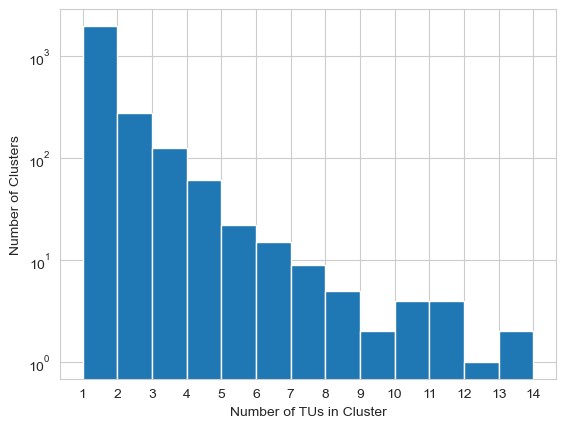

In [217]:
# Number of TUs in each cluster
tu_set_len_list = [len(tu_set) for tu_set in tu_set_list]

fig, ax = plt.subplots()
ax.hist(tu_set_len_list, bins=range(1,15))
ax.set_yscale('log')
ax.set_xlabel('Number of TUs in Cluster')
ax.set_ylabel('Number of Clusters')
ax.set_xticks(range(1,15))

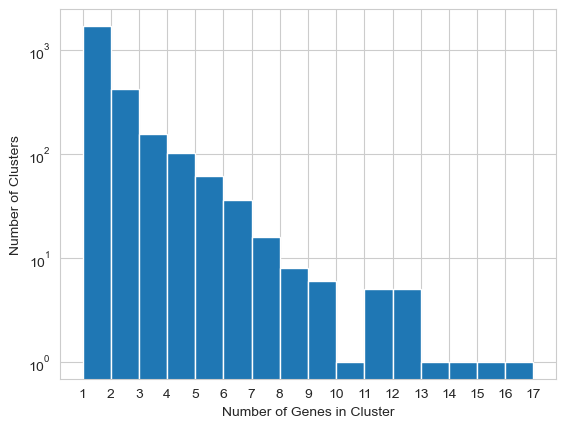

In [234]:
# Number of genes in each cluster
gene_set_list = []

for tu_set in tu_set_list:
    # Set of genes in each TU cluster
    common_gene = set()
    for tu in tu_set:
        common_gene.update(gene_tu.loc[gene_tu.loc[:,tu] == 1].index)
    gene_set_list.append(common_gene)

gene_set_len_list = [len(gene_set) for gene_set in gene_set_list]

fig, ax = plt.subplots()
ax.hist(gene_set_len_list, bins=range(1,18))
ax.set_yscale('log')
ax.set_xlabel('Number of Genes in Cluster')
ax.set_ylabel('Number of Clusters')
ax.set_xticks(range(1,18))

In [194]:
# Code snippet for seeing genes associated with any TU
gene_tu.loc[gene_tu.loc[:,'ECK120009144'] == 1]

locus_tag,ECK120008913,ECK120008914,ECK120008915,ECK120008916,ECK120008917,ECK120008918,ECK120008919,ECK120008920,ECK120008921,ECK120008922,...,ECK125300411,ECK125300412,ECK125300413,ECK125302594,ECK125302595,ECK125302596,ECK125302597,ECK125328143,ECK125336160,ECK125336161
locus_tag,,,,,,,,,,,,,,,,,,,,,
b2937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Distance From TSS Matrix

In [460]:
distance_df = pd.DataFrame(0, index=gene_tu.index, columns=gene_tu.columns)

# Loop over all of the TUs in the gene_tu DataFrame
for TU in gene_tu.columns:
    # NOTE: Not sure how to deal with cases where we don't have tss information
    # Should I just use left/right depending on whether it's forward/reverse?
    if pd.isna(mg1655.tu_table.loc[TU, 'tss']):
        continue
    
    # Location of the TU tss
    location_tu = mg1655.tu_table.loc[TU, 'tss']

    # Temporary list of genes belonging to that TU
    gene_list = gene_tu.loc[gene_tu.loc[:, TU] == 1].index.to_list()

    # Calculate distance from TU start and add to distance_df
    for gene in gene_list:
        # For genes that are on the reverse strand, use the 'right' label
        if mg1655.gene_table.loc[gene, 'strand'] == -1:
            location_gene = mg1655.gene_table.loc[gene, 'right']
        else:
            location_gene = mg1655.gene_table.loc[gene, 'left']

        distance_df.loc[gene, TU] = abs(location_tu-location_gene)

In [523]:
# NOTE: This version uses left/right
distance_df = pd.DataFrame(0, index=gene_tu.index, columns=gene_tu.columns)

# Loop over all of the TUs in the gene_tu DataFrame
for TU in gene_tu.columns:
    # Temporary list of genes belonging to that TU
    gene_list = gene_tu.loc[gene_tu.loc[:, TU] == 1].index.to_list()

    # Calculate distance from TU start and add to distance_df
    for gene in gene_list:
        # For genes that are on the reverse strand, use the 'right' label
        if mg1655.gene_table.loc[gene, 'strand'] == -1:
            location_gene = mg1655.gene_table.loc[gene, 'right']
            location_tu = mg1655.tu_table.loc[TU, 'right']
        else:
            location_gene = mg1655.gene_table.loc[gene, 'left']
            location_tu = mg1655.tu_table.loc[TU, 'left']

        distance_df.loc[gene, TU] = abs(location_tu-location_gene)

In [461]:
distance_df.loc[gene_tu.loc[:,'ECK120008913'] == 1].sort_values(by='ECK120008913').index.to_list()[0]

'b1748'

## Graph How Transcription Decreases with Distance from TSS
Want to include the first gene in the TU, and all genes downstream of it that do not have an additional TU in the way

ECK120008960
ECK120008965
ECK120008970
ECK120008972
ECK120009002
ECK120009026
ECK120009070
ECK120009079
ECK120009141
ECK120009143
ECK120009145
ECK120009159
ECK120009214
ECK120009223
ECK120009228
ECK120009237
ECK120009247
ECK120009306
ECK120009315
ECK120009342
ECK120009344
ECK120009347
ECK120009348
ECK120009352
ECK120009364
ECK120009384
ECK120009388
ECK120009396
ECK120009403
ECK120009405
ECK120009406
ECK120009415
ECK120009424
ECK120009429
ECK120009444
ECK120009458
ECK120009476
ECK120009478
ECK120009480
ECK120009491
ECK120009495
ECK120009501
ECK120009502
ECK120009509
ECK120009513
ECK120009539
ECK120009542
ECK120009543
ECK120009548
ECK120009552
ECK120009608
ECK120009720
ECK120009729
ECK120009736
ECK120009798
ECK120009803
ECK120009811
ECK120009812
ECK120009822
ECK120010890
ECK120010892
ECK120010912
ECK120010928
ECK120010931
ECK120010933
ECK120010936
ECK120011121
ECK120015332
ECK120015475
ECK120016220
ECK120016549
ECK120016698
ECK120016724
ECK120017000
ECK120026522
ECK120026528
ECK120026550

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


ECK120027571
ECK120027592
ECK120027596
ECK120027602
ECK120027663
ECK120027691
ECK120027704
ECK120027719
ECK120027737
ECK120027745
ECK120027750
ECK120027765
ECK120027766
ECK120027776
ECK120027790
ECK120027800
ECK120027809
ECK120027820
ECK120027836
ECK120027847
ECK120027863
ECK120027864
ECK120027870
ECK120027874
ECK120027879
ECK120029327
ECK120030189
ECK120034111
ECK125136336


Text(0, 0.5, 'Relative log2[TPM]')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


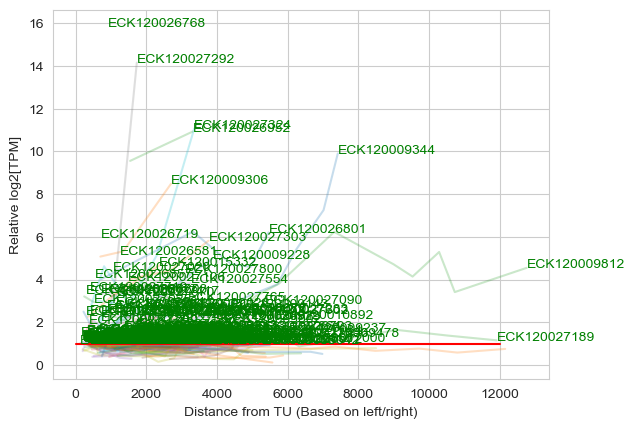

In [598]:
fig, ax = plt.subplots()
j = 0 # Number of TUs

total_distance_list = []
total_expression_list = []

for i, length in enumerate(tu_set_len_list):
    if length != 1:
        continue

    distance_list = []
    expression_list = []
    
    for TU in tu_set_list[i]:
        # Check to make sure we have a TSS for it
        # NOTE: No longer using
        #if pd.isna(mg1655.tu_table.loc[TU, 'tss']):
            #continue

        # Determine the first gene in the TU to find relative expression
        ordered_genes = distance_df.loc[gene_tu.loc[:,TU] == 1].sort_values(by=TU).index.to_list()
        first_gene = ordered_genes[0]
        
        # Append distance and expression from distance_df and mg1655.gene_table
        # Exclue the first gene so that the histogram results aren't skewed
        for gene in ordered_genes[1:]:
            # Remove zeroes in order to fit a line with numpy
            if mg1655.gene_table.loc[gene,'p1k_ctrl_log_tpm'] == 0 or pd.isna(mg1655.gene_table.loc[gene,'p1k_ctrl_log_tpm']):
                continue
            
            distance_list.append(distance_df.loc[gene, TU])
            expression_list.append(mg1655.gene_table.loc[gene,'p1k_ctrl_log_tpm']/mg1655.gene_table.loc[first_gene,'p1k_ctrl_log_tpm'])
            total_distance_list.append(distance_df.loc[gene, TU])
            total_expression_list.append(mg1655.gene_table.loc[gene,'p1k_ctrl_log_tpm']/mg1655.gene_table.loc[first_gene,'p1k_ctrl_log_tpm'])

        if not expression_list:
            continue
        else:
            j += 1

        if expression_list[-1] > 1:
            print(TU)
            ax.text(x=distance_list[-1], y=expression_list[-1], s=TU, c='g')

        ax.plot(distance_list, expression_list, alpha=0.25, label=TU)

ax.plot([0,12000], [1,1], c='r')
ax.set_xlabel('Distance from TU (Based on left/right)')
ax.set_ylabel('Relative log2[TPM]')

In [ ]:
# Figure out how to only plot ECK120009344


In [599]:
j

455

In [600]:
len(total_distance_list)

856

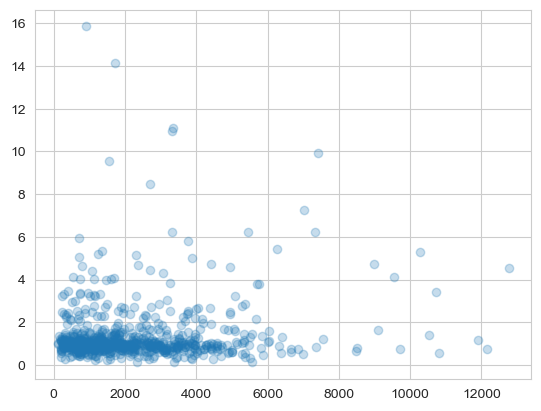

In [720]:
_, ax = plt.subplots()
ax.scatter(total_distance_list, total_expression_list, alpha=0.25)
#ax.plot([0,12000], [1,1], c='r')
#ax.set_yscale('log')

In [384]:
c = np.polynomial.polynomial.polyfit(x=distance_list, y=expression_list, deg=1)
p = np.polyval(p=z, x=distance_list)


In [385]:
np.polynomial.polynomial.polyfit(x=distance_list, y=expression_list, deg=1)

array([nan, nan])

In [561]:
np.polyfit(total_distance_list, total_expression_list, deg=1)

array([nan, nan])

Text(0.5, 1.0, 'Frequency of Relative Expression for Genes with Only One TU')

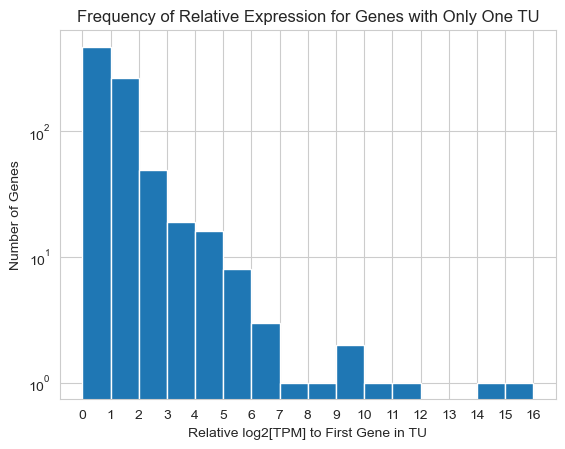

In [605]:
_, ax = plt.subplots()
ax.hist(total_expression_list, bins=range(0,17))
ax.set_xticks(range(0,17))
ax.set_yscale('log')
ax.set_xlabel('Relative log2[TPM] to First Gene in TU')
ax.set_ylabel('Number of Genes')
ax.set_title('Frequency of Relative Expression for Genes with Only One TU')

In [399]:
test_list = []
if not test_list:
    print('test')

test


## Create Equations to Describe Expression of Each Gene Based on TUs

In [524]:
import sympy

# Create symbolic variables out of all of the RegulonDB TU names
column_symbols = [sympy.symbols(column) for column in gene_tu.columns]

def create_symbolic_sum(row):
    terms = [symbol * value for symbol, value in zip(column_symbols, row)]
    return sympy.Add(*terms)

In [525]:
symbolic_df = pd.DataFrame(data=gene_tu.apply(create_symbolic_sum, axis=1), index=distance_df.index, columns=['equation'])

In [526]:
symbolic_df

,equation
locus_tag,
b0001,ECK120009369 + ECK125145761
b0002,ECK120009369
b0003,ECK120009369
b0004,ECK120009369
b0005,ECK120026504
...,...
b4399,ECK120009443 + ECK120033564
b4400,ECK120009443 + ECK120034932
b4401,ECK120009741 + ECK120009742 + ECK120009743 + E...


Subtract the distance from the TSS, using some unknown function $d$

In [527]:
d = Function('d')

for gene in symbolic_df.index:
    row = distance_df.loc[gene,:]
    nonzero_columns = row.loc[row != 0].index.to_list()

    for column in nonzero_columns:
        symbolic_df.loc[gene] = symbolic_df.loc[gene] + d(distance_df.loc[gene, column])
    
    print(gene, symbolic_df.loc[gene])

b0001 equation    ECK120009369 + ECK125145761 + 2*d(42)
Name: b0001, dtype: object
b0002 equation    ECK120009369 + d(189)
Name: b0002, dtype: object
b0003 equation    ECK120009369 + d(2653)
Name: b0003, dtype: object
b0004 equation    ECK120009369 + d(3586)
Name: b0004, dtype: object
b0005 equation    ECK120026504
Name: b0005, dtype: object
b0006 equation    ECK120026505
Name: b0006, dtype: object
b0007 equation    ECK120026506
Name: b0007, dtype: object
b0008 equation    ECK120015352 + d(47)
Name: b0008, dtype: object
b0009 equation    ECK120026507
Name: b0009, dtype: object
b0010 equation    ECK120026508
Name: b0010, dtype: object
b0011 equation    ECK120026509
Name: b0011, dtype: object
b0013 equation    ECK120020482
Name: b0013, dtype: object
b0014 equation    ECK120009450 + ECK120009602 + ECK120009603 + d...
Name: b0014, dtype: object
b0015 equation    ECK120009450 + ECK120009602 + ECK120009603 + d...
Name: b0015, dtype: object
b0016 equation    ECK120026510
Name: b0016, dtype: o

In [585]:
mg1655._gene_to_tus['b4486']

[]

In [590]:
mg1655.gene_table.loc['b4486']

left                   4573919
right                  4576855
strand                       1
pseudo                    True
name                      yjiV
cog                        NaN
essential                  NaN
y-ome                 excluded
p1k_ctrl_log_tpm      3.721728
p1k_median_log_tpm    3.692066
p1k_mad_log_tpm       0.574085
in_iM                    False
median_log_tpm        3.714199
mad_log_tpm           0.378071
pct10_log_tpm              NaN
pct25_log_tpm              NaN
max_log_tpm           6.321623
min_log_tpm           1.467366
mean_log_tpm          3.688307
skew                  0.138038
range_log_tpm         4.854257
max_to_median         2.607424
min_to_median        -2.246833
low                      False
in_complex               False
Name: b4486, dtype: object

In [537]:
symbolic_df.loc['b4401', 'equation']

ECK120009741 + ECK120009742 + ECK120009743 + ECK120009744 + ECK120009745 + ECK120009746 + ECK120009747 + d(202) + d(206) + d(229) + d(293) + d(375) + d(382) + d(495)

In [528]:
gene, column

('b4403', 'ECK120009747')

In [543]:
mg1655._gene_to_tus['b4314']

[]

In [538]:
mg1655.gene_table.loc['b4314']

left                         4543115
right                        4543663
strand                             1
pseudo                         False
name                            fimA
cog                                N
essential                        NaN
y-ome                 well-annotated
p1k_ctrl_log_tpm            9.115775
p1k_median_log_tpm         10.160033
p1k_mad_log_tpm             1.324335
in_iM                           True
median_log_tpm              10.18594
mad_log_tpm                 0.867479
pct10_log_tpm                    NaN
pct25_log_tpm                    NaN
max_log_tpm                14.565851
min_log_tpm                 4.778869
mean_log_tpm               10.092919
skew                       -0.594809
range_log_tpm               9.786982
max_to_median               4.379911
min_to_median              -5.407071
low                            False
in_complex                     False
Name: b4314, dtype: object

In [535]:
mg1655.tu_table.loc['ECK120026502']

name                 yjjY
strand                1.0
tss                   NaN
sigma_factor          NaN
box_10_left           NaN
box_10_right          NaN
box_35_left           NaN
box_35_right          NaN
left            4640402.0
right           4640542.0
Name: ECK120026502, dtype: object

In [512]:
row = distance_df.loc['b0001',:]
nonzero_columns = row.loc[row != 0].index.to_list()
nonzero_columns

['ECK120009369', 'ECK125145761']

# Case Studies

## Threonine Biosynthesis

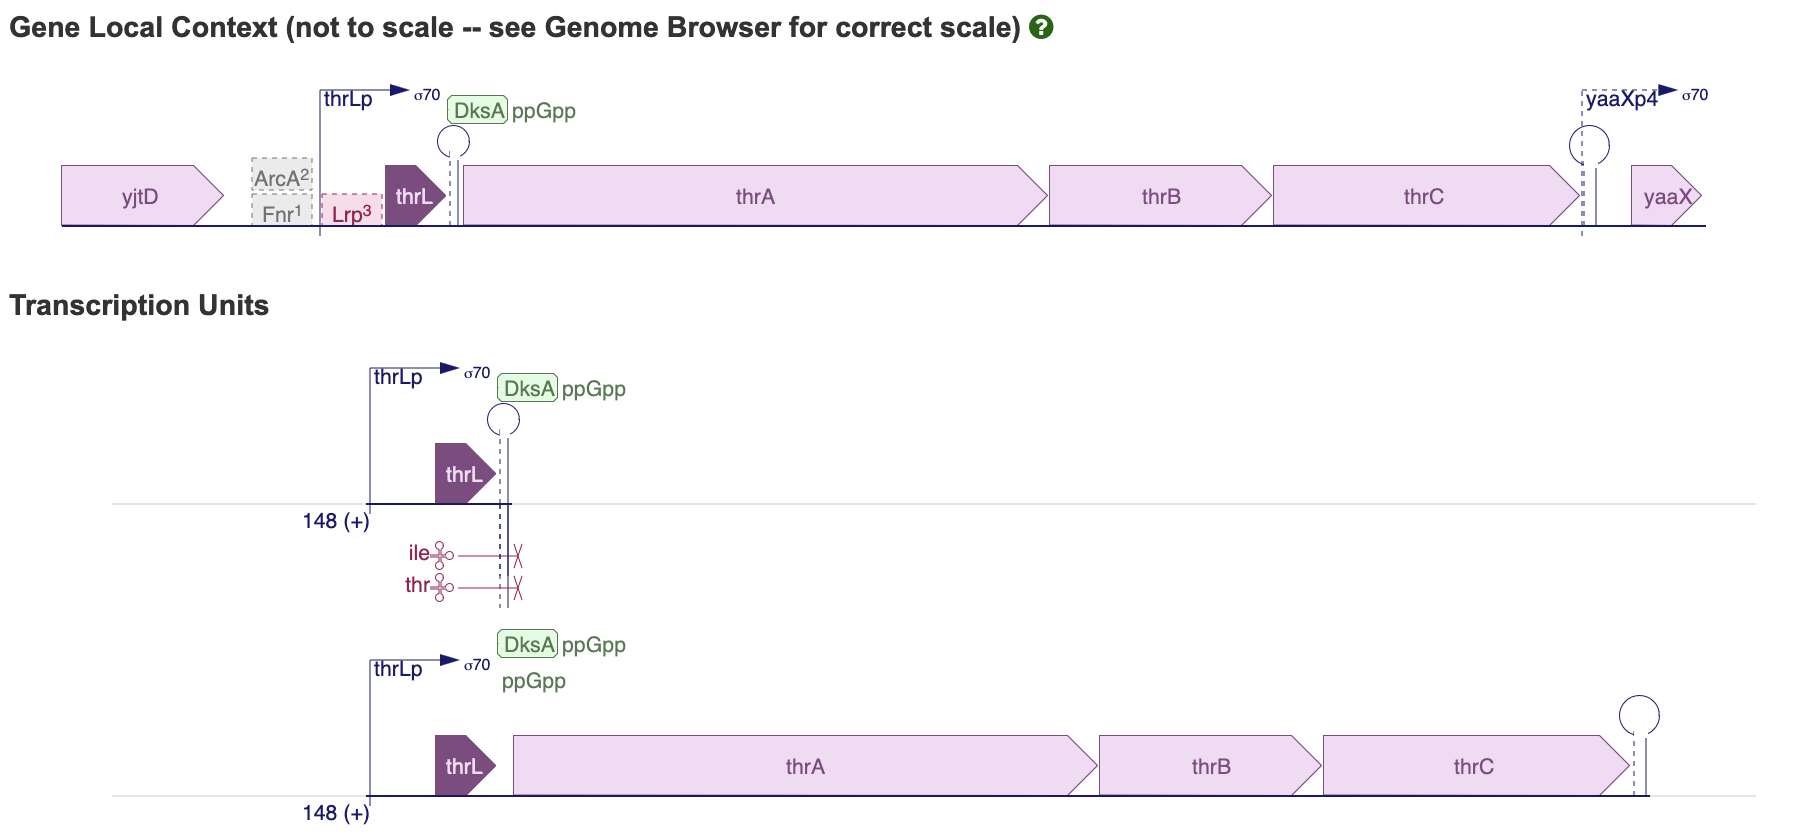

In [7]:
mg1655.gene_table.loc['b0001':'b0004',:]

,left,right,strand,pseudo,name,cog,essential,y-ome,p1k_ctrl_log_tpm,p1k_median_log_tpm,...,pct25_log_tpm,max_log_tpm,min_log_tpm,mean_log_tpm,skew,range_log_tpm,max_to_median,min_to_median,low,in_complex
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0001,190,255,1,False,thrL,NaN,NaN,well-annotated,10.372833,8.862343,...,7.633022,14.327388,0.000000,9.079599,0.248526,14.327388,5.465045,-8.862343,False,True
b0002,337,2799,1,False,thrA,E,NaN,well-annotated,10.314562,9.605329,...,8.701393,11.771901,0.000000,9.268791,-1.946621,11.771901,2.166572,-9.605329,False,True
b0003,2801,3733,1,False,thrB,E,NaN,well-annotated,9.982251,9.232803,...,8.390286,11.460140,4.491162,8.992904,-0.955742,6.968977,2.227337,-4.741641,False,True
b0004,3734,5020,1,False,thrC,E,NaN,well-annotated,9.973666,9.274271,...,8.477273,11.319964,4.332273,8.973294,-1.313123,6.987691,2.045694,-4.941998,False,True


In [8]:
mg1655._gene_to_tus['b0001']

['ECK120009369', 'ECK125145761']

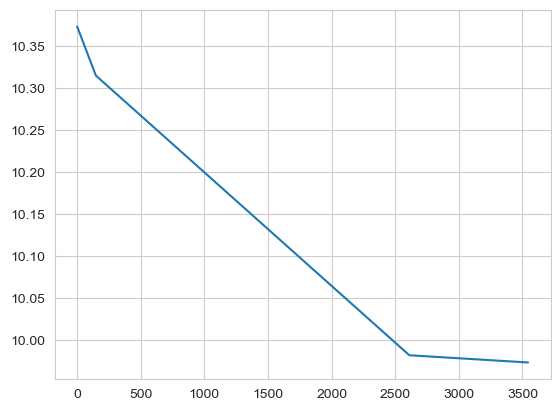

In [9]:
# Want to see how expression falls off with distance from TU
fig, ax = plt.subplots()
ax.plot(mg1655.gene_table.loc['b0001':'b0004',:].strand*(mg1655.gene_table.loc['b0001':'b0004',:].left-mg1655.gene_table.loc['b0001','left']), mg1655.gene_table.loc['b0001':'b0004',:].p1k_ctrl_log_tpm)

## L-arginine catabolism
L-arginine succinyltransferase pathway

In [10]:
mg1655.gene_table.loc['b1744':'b1748',:]

,left,right,strand,pseudo,name,cog,essential,y-ome,p1k_ctrl_log_tpm,p1k_median_log_tpm,...,pct25_log_tpm,max_log_tpm,min_log_tpm,mean_log_tpm,skew,range_log_tpm,max_to_median,min_to_median,low,in_complex
locus_tag,,,,,,,,,,,,,,,,,,,,,
b1744,1825955,1826923,-1,False,astE,E,NaN,well-annotated,2.579823,2.065670,...,1.413994,8.369789,0.000000,2.313911,1.656656,8.369789,6.304119,-2.065670,False,True
b1745,1826916,1828259,-1,False,astB,E,NaN,well-annotated,3.068883,2.780018,...,2.164788,8.846202,0.183110,3.042825,1.477441,8.663092,6.066184,-2.596908,False,True
b1746,1828256,1829734,-1,False,astD,C,NaN,well-annotated,3.389045,2.718973,...,2.045329,8.914281,0.328371,2.988698,1.497376,8.585911,6.195308,-2.390603,False,True
b1747,1829731,1830765,-1,False,astA,E,NaN,well-annotated,3.941224,2.766048,...,1.584693,9.522742,0.000000,3.011044,0.981743,9.522742,6.756694,-2.766048,False,True
b1748,1830762,1831982,-1,False,astC,E,NaN,well-annotated,4.060970,3.005525,...,1.786603,10.160423,0.000000,3.251487,0.983851,10.160423,7.154898,-3.005525,False,True


In [11]:
mg1655._gene_to_tus['b1744']

['ECK120008913', 'ECK120008914', 'ECK120008915']

In [12]:
mg1655.tu_table.loc['ECK120008913':'ECK120008915',:]

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,
ECK120008913,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0
ECK120008914,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0
ECK120008915,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0


NOTE: astEp3 is not included in the mg1655.tu_table

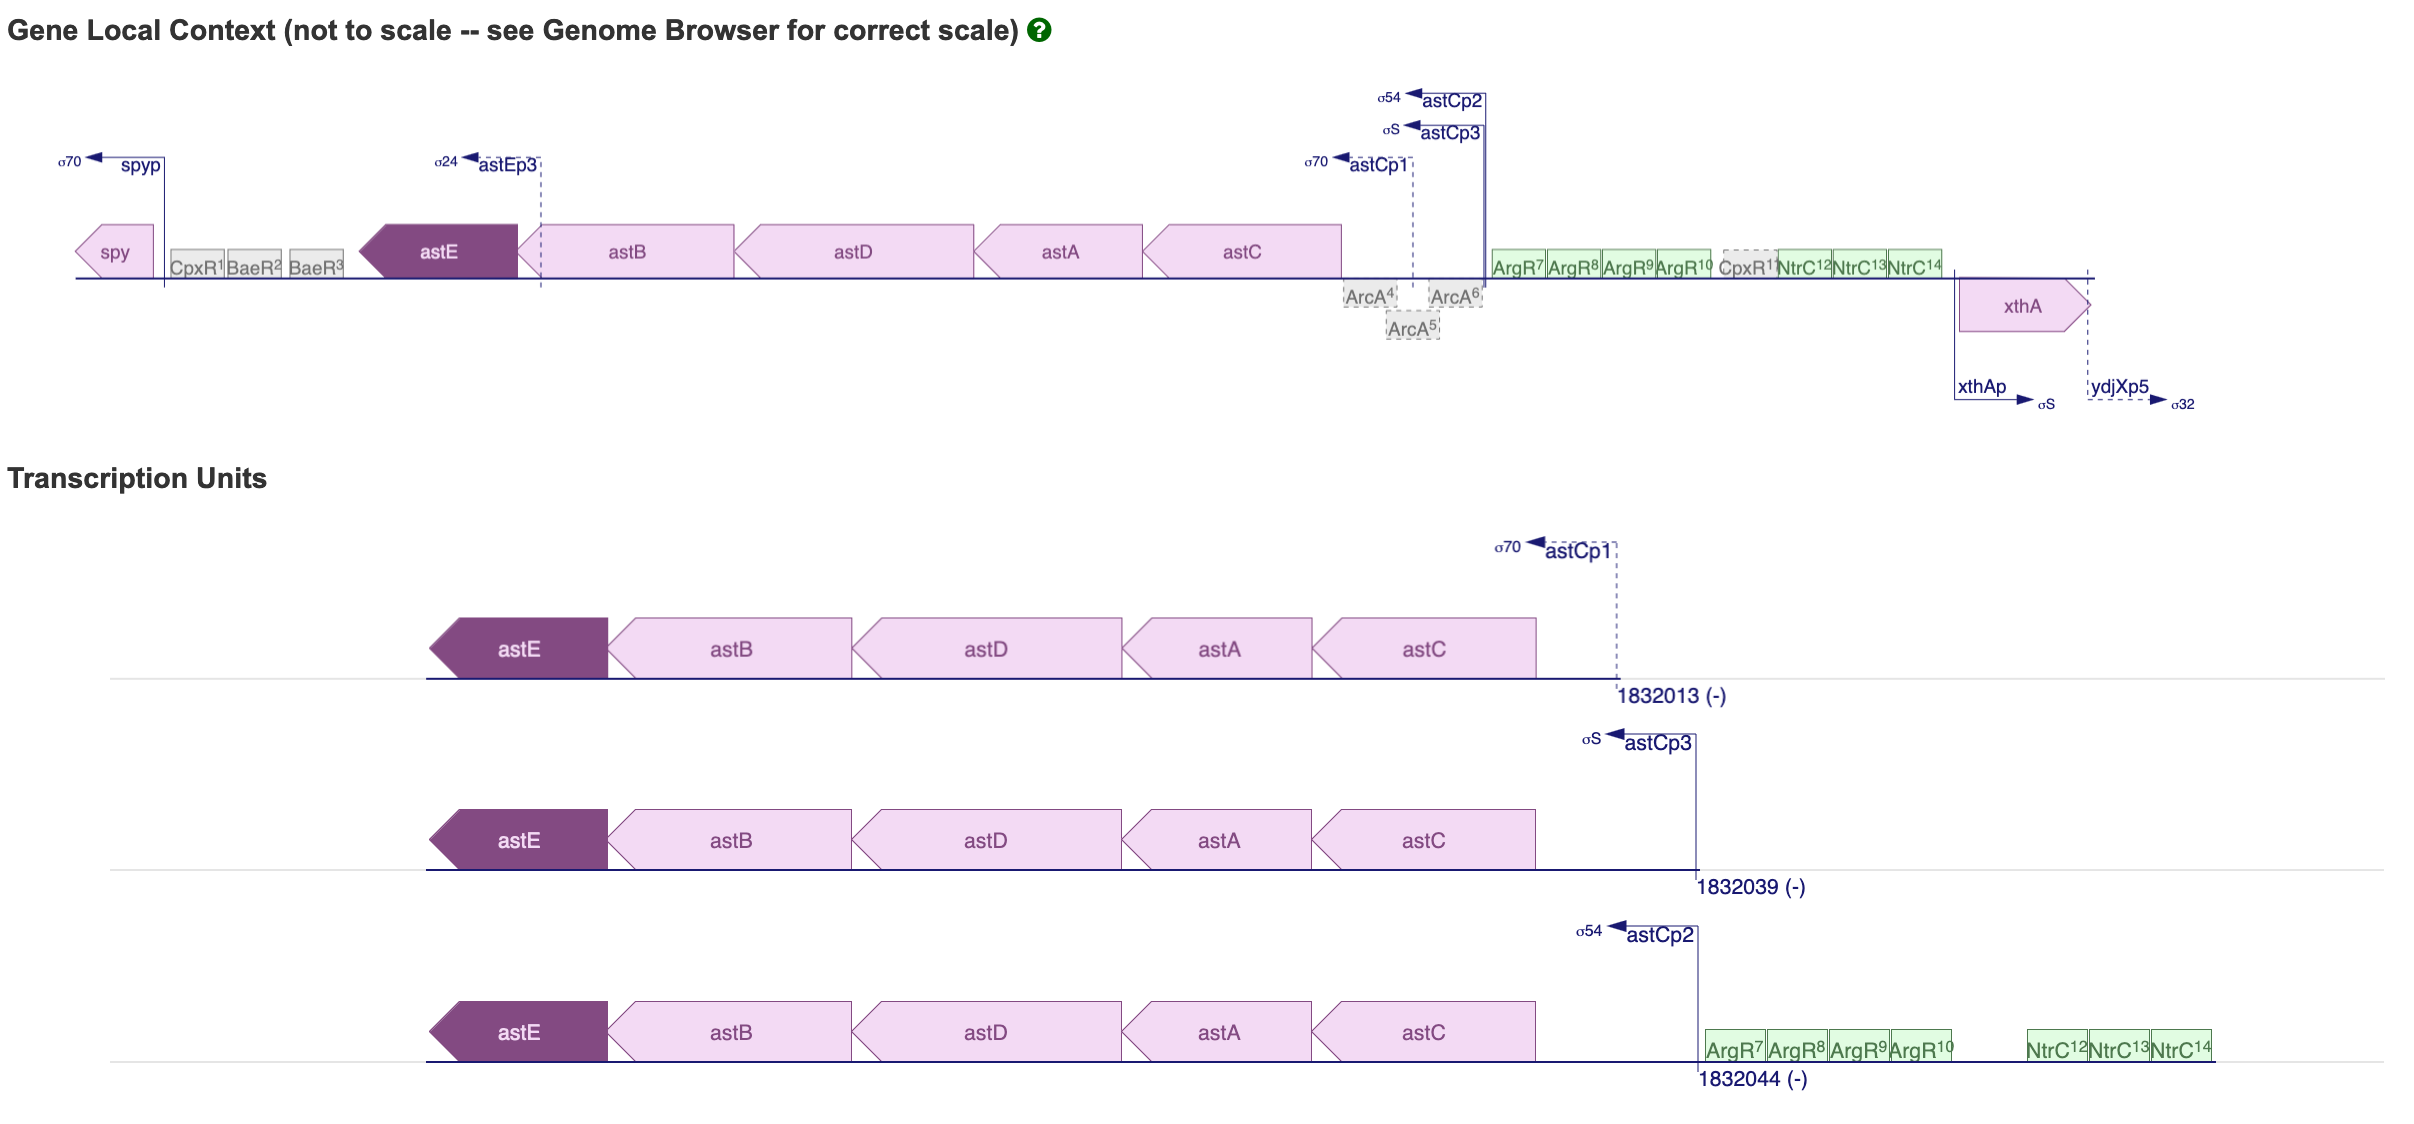

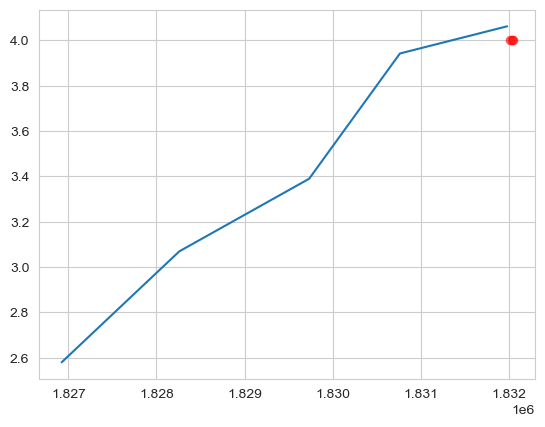

In [13]:
# Want to see how expression falls off with distance from TU
fig, ax = plt.subplots()
ax.plot(mg1655.gene_table.loc['b1744':'b1748','right'], mg1655.gene_table.loc['b1744':'b1748',:].p1k_ctrl_log_tpm)
ax.scatter(mg1655.tu_table.loc['ECK120008913':'ECK120008915',:].tss, np.repeat(4, 3), c='r', alpha=0.5)

In [14]:
# I'm not entirely sure what the in_complex column is
mg1655.gene_table.in_complex.value_counts()

True     2248
False    2036
Name: in_complex, dtype: int64

## Threonylcarbamoyl-6-adenosine (tsa)

Involves b4167-b4175 and 11 TUs

In [573]:
gene_list = mg1655.gene_table.loc['b4167':'b4175'].index
mg1655.gene_table.loc[gene_list]

,left,right,strand,pseudo,name,cog,essential,y-ome,p1k_ctrl_log_tpm,p1k_median_log_tpm,...,pct25_log_tpm,max_log_tpm,min_log_tpm,mean_log_tpm,skew,range_log_tpm,max_to_median,min_to_median,low,in_complex
locus_tag,,,,,,,,,,,,,,,,,,,,,
b4167,4394066,4395613,1,False,nnr,F,NaN,well-annotated,6.205819,5.602110,...,5.105450,8.416431,3.403000,5.650767,0.435209,5.013431,2.814321,-2.199110,False,True
b4168,4395585,4396046,1,False,tsaE,J,True,well-annotated,6.358507,6.103373,...,5.740114,7.890602,4.065240,6.078541,-0.316439,3.825362,1.787229,-2.038133,False,True
b4169,4396065,4397402,1,False,amiB,M,NaN,well-annotated,5.990108,6.044177,...,5.770271,7.640732,4.114911,6.046060,-0.347128,3.525821,1.596555,-1.929266,False,True
b4170,4397412,4399259,1,False,mutL,L,NaN,well-annotated,6.193443,5.987722,...,5.716989,8.097861,4.038567,6.034312,0.416675,4.059294,2.110139,-1.949155,False,True
b4171,4399252,4400202,1,False,miaA,J,NaN,well-annotated,8.852992,9.172284,...,8.876558,10.939185,7.435251,9.193359,0.354815,3.503934,1.766901,-1.737033,False,True
b4172,4400288,4400596,1,False,hfq,T,NaN,well-annotated,10.452961,10.516163,...,10.282067,11.906837,9.326613,10.507895,0.216069,2.580225,1.390674,-1.189551,False,True
b4173,4400672,4401952,1,False,hflX,J,NaN,well-annotated,8.466683,8.402434,...,8.140616,10.048016,6.804100,8.422062,0.561041,3.243916,1.645582,-1.598334,False,True
b4174,4402038,4403297,1,False,hflK,O,NaN,well-annotated,8.857149,8.735900,...,8.473180,10.355877,6.773375,8.742104,-0.161895,3.582502,1.619977,-1.962525,False,True
b4175,4403300,4404304,1,False,hflC,O,NaN,well-annotated,8.765255,8.539234,...,8.255681,10.042246,6.576754,8.484642,-0.640194,3.465492,1.503012,-1.962480,False,True


In [55]:
# Identify the unique TUs in this set of genes
TU_list = [TU for gene in mg1655.gene_table.loc[gene_list].index for TU in mg1655._gene_to_tus[gene]]
TU_list = list(set(TU_list))
mg1655.tu_table.loc[TU_list,:]

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,
ECK120033765,mutL-miaA-hfq-hflXKC,1.0,4397046.0,Sigma32,4397031.0,4397036.0,4397011.0,4397016.0,4397046.0,4404304.0
ECK120009426,yjeFE-amiB-mutL-miaA-hfq-hflXKC,1.0,4393677.0,Sigma70,4393665.0,4393670.0,4393640.0,4393645.0,4393677.0,4404304.0
ECK120009829,yjeFE-amiB-mutL-miaA-hfq-hflXKC,1.0,4393937.0,Sigma70,4393925.0,4393930.0,4393899.0,4393904.0,4393937.0,4404304.0
ECK120009830,yjeFE-amiB-mutL-miaA-hfq-hflXKC,1.0,4394035.0,Sigma70,4394025.0,4394030.0,4394001.0,4394006.0,4394035.0,4404304.0
ECK120033605,hfq-hflXKC,1.0,4400220.0,Sigma70,4400208.0,4400213.0,4400183.0,4400188.0,4400220.0,4404304.0
ECK120033597,hfq-hflXKC,1.0,4399801.0,Sigma70,4399788.0,4399793.0,4399765.0,4399770.0,4399801.0,4404304.0
ECK120033766,mutL-miaA-hfq-hflXKC,1.0,4397100.0,Sigma70,4397088.0,4397093.0,4397064.0,4397069.0,4397100.0,4404304.0
ECK120051393,tsaE-amiB-mutL-miaA-hfq-hflXKC,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4395585.0,4404304.0
ECK120033603,miaA-hfq-hflXKC,1.0,4399052.0,Sigma70,4399039.0,4399044.0,4399013.0,4399018.0,4399052.0,4404304.0


In [574]:
mg1655.gene_table.loc[gene_list,:].p1k_ctrl_log_tpm

locus_tag
b4167     6.205819
b4168     6.358507
b4169     5.990108
b4170     6.193443
b4171     8.852992
b4172    10.452961
b4173     8.466683
b4174     8.857149
b4175     8.765255
Name: p1k_ctrl_log_tpm, dtype: float64

In [575]:
2**mg1655.gene_table.loc[gene_list,:].p1k_ctrl_log_tpm

locus_tag
b4167      73.813816
b4168      82.054296
b4169      63.562694
b4170      73.183306
b4171     462.398082
b4172    1401.699234
b4173     353.773725
b4174     463.732527
b4175     435.115580
Name: p1k_ctrl_log_tpm, dtype: float64

Text(0.5, 1.0, 'nnr-tsaE-amiB-mutL-miaA-hfq-hflXKC Operon')

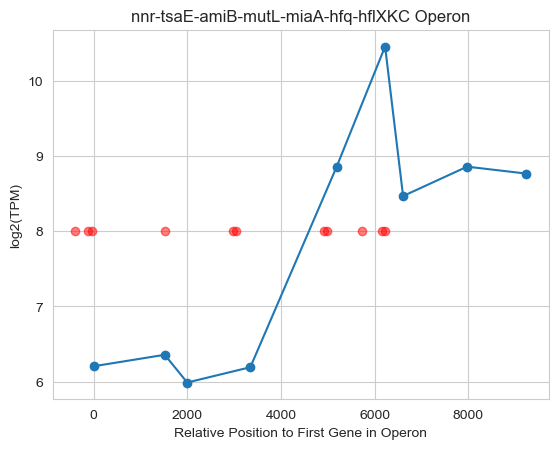

In [581]:
# Want to see how expression falls off with distance from TU
fig, ax = plt.subplots()
ax.plot(mg1655.gene_table.loc[gene_list,:].strand*(mg1655.gene_table.loc[gene_list,:].left-mg1655.gene_table.loc[gene_list[0],'left']), mg1655.gene_table.loc[gene_list,:].p1k_ctrl_log_tpm)
ax.scatter(mg1655.gene_table.loc[gene_list,:].strand*(mg1655.gene_table.loc[gene_list,:].left-mg1655.gene_table.loc[gene_list[0],'left']), mg1655.gene_table.loc[gene_list,:].p1k_ctrl_log_tpm)
ax.scatter(mg1655.tu_table.loc[TU_list,:].strand*(mg1655.tu_table.loc[TU_list,:].left-mg1655.gene_table.loc[gene_list[0],'left']), np.repeat(8, len(TU_list)), c='r', alpha=0.5)
ax.set_ylabel('log2(TPM)')
ax.set_xlabel('Relative Position to First Gene in Operon')
ax.set_title('nnr-tsaE-amiB-mutL-miaA-hfq-hflXKC Operon')

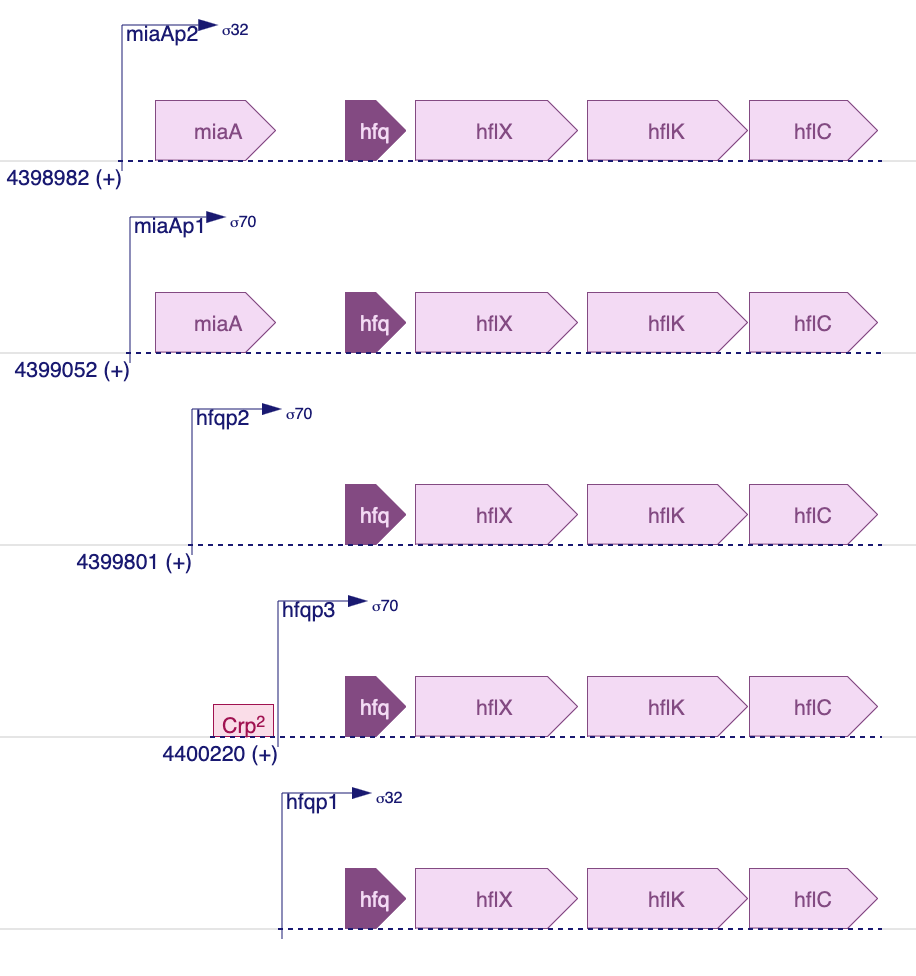

In [580]:
for gene in symbolic_df.loc[gene_list,:].index:
    print(str(gene) + ': ' + str(symbolic_df.loc[gene, 'equation']))

b4167: ECK120009426 + ECK120009829 + ECK120009830 + d(31) + d(129) + d(389)
b4168: ECK120009426 + ECK120009829 + ECK120009830 + ECK120051393 + d(1550) + d(1648) + d(1908)
b4169: ECK120009426 + ECK120009829 + ECK120009830 + ECK120051393 + d(480) + d(2030) + d(2128) + d(2388)
b4170: ECK120009426 + ECK120009829 + ECK120009830 + ECK120033765 + ECK120033766 + ECK120051393 + d(312) + d(366) + d(1827) + d(3377) + d(3475) + d(3735)
b4171: ECK120009426 + ECK120009829 + ECK120009830 + ECK120033602 + ECK120033603 + ECK120033765 + ECK120033766 + ECK120051393 + d(200) + d(270) + d(2152) + d(2206) + d(3667) + d(5217) + d(5315) + d(5575)
b4172: ECK120009426 + ECK120009829 + ECK120009830 + ECK120033597 + ECK120033602 + ECK120033603 + ECK120033604 + ECK120033605 + ECK120033765 + ECK120033766 + ECK120051393 + d(68) + d(487) + d(1236) + d(1306) + d(3188) + d(3242) + d(4703) + d(6253) + d(6351) + d(6611)
b4173: ECK120009426 + ECK120009829 + ECK120009830 + ECK120033597 + ECK120033602 + ECK120033603 + ECK12